# Solution to exercises for week 41-42
##### Brage Wiseth, Eirik Jahr, Felix Cameren


##### week 41

1. A plain gradient descent with a fixed learning rate (you will need to tune it) using the analytical expression of the gradients

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate), again using the analytical expression of the gradients.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD.

5. Add RMSprop and Adam to your library of methods for tuning the learning rate.

##### week 42 same as week 41 but using automatic differentiation

1. A plain gradient descent with a fixed learning rate (you will need to tune it) using automatic differentiation. Compare this with the analytical expression of the gradients you obtained last week. Feel free to use **Autograd** as Python package or **JAX**. You can use the examples form last week.

2. Add momentum to the plain GD code and compare convergence with a fixed learning rate (you may need to tune the learning rate). Compare this with the analytical expression of the gradients you obtained last week.

3. Repeat these steps for stochastic gradient descent with mini batches and a given number of epochs. Use a tunable learning rate as discussed in the lectures from week 39. Discuss the results as functions of the various parameters (size of batches, number of epochs etc)

4. Implement the Adagrad method in order to tune the learning rate. Do this with and without momentum for plain gradient descent and SGD using automatic differentiation..

5. Add RMSprop and Adam to your library of methods for tuning the learning rate. Again using automatic differentiation.

## Data

jax backend gpu


Text(0.5, 1.0, 'Scatter plot of noisy data')

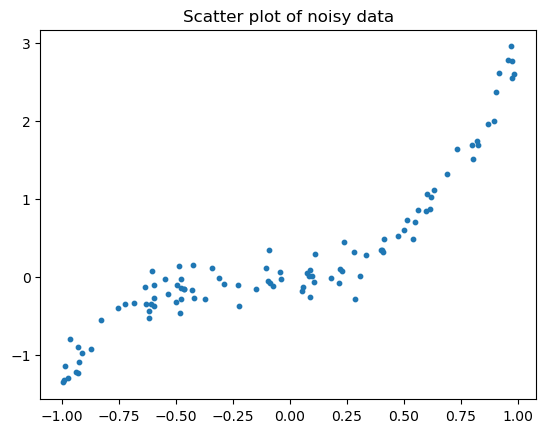

In [98]:
import numpy as onp
import jax.numpy as np
import jax
from matplotlib import pyplot as plt
from functools import partial
from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))


def f(x):
    return 0.2*x + 0.8*x**2 + 2*x**3

key = jax.random.PRNGKey(1234)
x = jax.random.uniform(key, shape=(100,), minval=-1, maxval=1)
key, subkey = jax.random.split(key)
y = f(x) + 0.15*jax.random.normal(subkey, shape=(100,))
plt.scatter(x, y, s=10)
plt.title("Scatter plot of noisy data")

## Preprocessing

In [99]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

poly = PolynomialFeatures(degree=3, include_bias=False)
scaler = StandardScaler()

X = poly.fit_transform(x.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train_mean = y_train.mean()
y_train = y_train - y_train_mean
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

## Methods
### Parent class for all methods

In [100]:
class Optimizer:
    def __init__(self):
        pass

    def __call__(self, grads, params, eta ):
        params -= eta * grads
        return params

### Jit compiling functions
In hope of speeding up the code, the tradeoff is that the code is not as readable and organised

In [101]:
@jax.jit
def MSE(w, X , y):
    y_pred = X @ w
    return np.mean((y_pred - y)**2)

@jax.jit
def MSE_Ridge(w, X, y, alpha):
    y_pred = X @ w
    return np.mean((y_pred - y)**2) + alpha*np.sum(w**2)



def print_message(message):
    print(f"\r{message: <100}", end='')



@jax.jit
def gradients(X, t, N, w):
    return 2/N * X.T @ (X @ w - t)



@jax.jit
def run_epochs(epochs:int, eta:float, X:np.array, t:np.array, batch_size:int , X_val:np.array, t_val:np.array , tol:float, optimizer, optimizerState ) -> (np.array, np.array):
    (N, m) = X_train.shape
    w = np.zeros(m)
    batches = int(N/batch_size)
    key = jax.random.PRNGKey(1234)
    loss = np.zeros(epochs)
    for e in range(epochs):
        for _ in range(batches):
            key, subkey = jax.random.split(key)
            random_index = batch_size* jax.random.randint(subkey, minval=0, maxval=batches, shape=())
            g = gradients( X[random_index:random_index+batch_size], t[random_index:random_index+batch_size], N, w   )
            w, optimizerState = optimizer(g, w, eta, optimizerState )
            loss = loss.at[e].set(MSE(w, X_val, t_val))
            if e > 10 and np.abs(loss[e-10] - loss[e]) < tol:
                loss = loss.at[e+1:].set(loss[e])
                print_message(f"Early stopping at epoch {e}")
                return
    print_message(f"Did not converge after {e} epochs")
    return loss, w


@jax.jit
def run_epochs_no_val(epochs:int,eta:float, X:np.array, t:np.array, batch_size:int , tol:float, optimizer, optimizerState ) -> (np.array, np.array):
    (N, m) = X_train.shape
    batches = int(N/batch_size)
    key = jax.random.PRNGKey(1234)
    loss = np.zeros(epochs)
    for e in range(epochs):
        for _ in range(batches):
            key, subkey = jax.random.split(key)
            random_index = batch_size* jax.random.randint(subkey, minval=0, maxval=batches, shape=())
            g = gradients( X[random_index:random_index+batch_size], t[random_index:random_index+batch_size], N, w   )
            w, optimizerState = optimizer(g, w, eta, optimizerState )
            loss = loss.at[e].set(MSE(w, X, t))
            if e > 10 and np.abs(loss[e-10] - loss[e]) < tol:
                loss = loss.at[e+1:].set(loss[e])
                print_message(f"Early stopping at epoch {e}")
                return
    print_message(f"Did not converge after {e} epochs")
    return loss, w

### Analytical

In [102]:
class AnalyticalLinReg:
    def __init__(self):
        self.weights = None

    def score(self, X, t):
        return MSE(self.weights, X, t)

    def fit(self, X_train, t_train):
        self.weights = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ t_train

### Gradient descent with hessian matrix inverse (gets computationaly heavy real quick)

In [103]:
class HessianInvGD(Optimizer):
    def __init__(self, X):
        self.hessian = (2.0/X.shape[0]) * (X.T @ X)


    def __call__(self, grads, params, eta ):
        grads = np.linalg.inv(self.hessian) @ grads
        params -= grads
        return params

### Standard gradient descent (with optional momentum)

In [104]:
from typing import NamedTuple
# class SGD(Optimizer):

#     def __init__(self, gamma=0):
#         self.gamma = gamma
#         self.change = 0


#     @partial(jax.jit, static_argnums=(0,))
#     def __call__(self, grads, params, eta ):
#         self.change = eta * grads + self.gamma * self.change
#         params -= self.change
#         return params 
class SGDState(NamedTuple):
    change: np.array
    gamma: float


def SGD(grads, params, eta, state:SGDState ):
    state.change = eta * grads + state.gamma * state.change
    params -= state.change
    return params, state


### Ridge gradient descent (with optional momentum)

In [105]:
class RidgeGD(Optimizer):

    def __init__(self, alpha=0.1, gamma=0):
        self.alpha = alpha
        self.gamma = gamma
        self.change = 0

    def __call__(self, grads, params, eta ):
        grads = grads + 2 * self.alpha * params
        self.change = eta * grads + self.gamma * self.change
        params -= self.change
        return params

### Adagrad (with optional momentum)

In [106]:
class Adagrad(Optimizer):

    def __init__(self, epsilon=1e-8, gamma=0):
        self.gamma = gamma
        self.epsilon = epsilon
        self.G = 0
        self.change = 0

    def __call__(self, grads, params, eta ):
        self.G += grads**2
        self.change = eta*grads / (np.sqrt(self.G) + self.epsilon) + self.gamma * self.change
        params -= self.change 
        return params

### RMSprop

In [107]:
class RMSprop(Optimizer):

    def __init__(self, epsilon=0.0001, decay=0.9):
        self.epsilon = epsilon
        self.G = 0
        self.decay = decay

    def __call__(self, grads, params, eta ):
        self.G = self.decay * self.G + (1-self.decay) * grads**2
        params -= eta * grads / (np.sqrt(self.G) + self.epsilon)
        return params

### Adam

In [108]:
class Adam(Optimizer):

    def __init__(self,  epsilon=0.0001, beta1=0.9, beta2=0.999):
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.beta1 = beta1
        self.beta2 = beta2

    def __call__(self, grads, params, eta ):
        self.m = self.beta1 * self.m + (1-self.beta1) * grads
        self.v = self.beta2 * self.v + (1-self.beta2) * grads**2
        m_hat = self.m / (1-self.beta1)
        v_hat = self.v / (1-self.beta2)
        params -= eta * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return params

In [109]:



# Super class for all linear regression models
class NumpyLinReg():

    def __init__(self , eta=0.1, epochs=100, tol=0.001, optimizer=SGD, optimizerState=SGDState(0,0)):
        self.eta = eta
        self.epochs = epochs
        self.tol = tol
        self.optimizer = optimizer

    def fit(self, X_train, t_train, X_val=None, t_val=None, batch_size=X_train.shape[0]):

        if (X_val is None) or (t_val is None): 
            self.loss, self.weights = run_epochs_no_val(self.epochs, X_train, t_train, batch_size, self.tol, self.optimizer ) 

        else:
            self.loss, self.weights = run_epochs(self.epochs, X_train, t_train, batch_size,  X_val, t_val, self.tol, self.optimizer )


    def predict(self, X):
        return np.dot(X, self.weights)


## Results

In [110]:
etas = [ 0.0001, 0.001, 0.001, 0.01, 0.25]
epochs = 200
tol = 0.001
gammas = [0.0, 0.1, 0.5, 0.9]
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0]
epsilon = 1e-8
decay = 0.9
beta1 = 0.9
beta2 = 0.999

def progress_bar(current, total, bar_length=20):
    fraction = current / total

    arrow = int(fraction * bar_length - 1) * '-' + '>'
    padding = int(bar_length - len(arrow)) * ' '

    return f'Progress: [{arrow}{padding}] {int(fraction*100)}%'




def runGD():
    scoresSgd = np.zeros((len(etas), len(gammas),epochs))
    scoresRidge = np.zeros((len(etas), len(gammas),len(alphas), epochs))
    for i, eta in enumerate(etas):
        for j, gamma in enumerate(gammas):
            sgd     =   NumpyLinReg(eta=eta, epochs=epochs, tol=tol, optimizer=SGD, optimizerState=SGDState(0, gamma))
            sgd.fit(X_train, y_train, X_test, y_test)
            scoresSgd = scoresSgd.at[i,j,:].set(sgd.loss)
            print(progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))
            for k, alpha in enumerate(alphas):
                ridgeGd     = NumpyLinReg(eta=eta, epochs=epochs, tol=tol, optimizer=RidgeGD(alpha=alpha, gamma=gamma))
                ridgeGd.fit(X_train, y_train, X_test, y_test)
                scoresRidge = scoresRidge.at[i,j,k,:].set(ridgeGd.loss)
    return scoresSgd,  scoresRidge






def runSTG(batch_size=5):    
    scoresAdagrad = np.zeros((len(etas), len(gammas),epochs))
    scoresRmsprop = np.zeros((len(etas), epochs))
    scoresAdam = np.zeros((len(etas), epochs))
    scoresHessianGd = np.zeros((len(etas),epochs))    
    scoresSgd = np.zeros((len(etas), len(gammas),epochs))
    scoresRidge = np.zeros((len(etas), len(gammas),len(alphas), epochs))
    for i, eta in enumerate(etas):
        hessianGd = HessianInvGD(eta=eta, epochs=epochs, tol=tol)
        rmsprop = RMSprop(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, decay=decay)
        adam = Adam(eta=eta, epochs=epochs, tol=tol, epsilon=epsilon, beta1=beta1, beta2=beta2)
        hessianGd.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        rmsprop.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        adam.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
        scoresHessianGd = scoresHessianGd.at[i,:].set(hessianGd.loss)
        scoresRmsprop = scoresRmsprop.at[i,:].set(rmsprop.loss)
        scoresAdam =  scoresAdam.at[i,:].set(adam.loss)
        for j, gamma in enumerate(gammas):
            sdg = SGD(eta=eta, epochs=epochs, tol=tol, gamma=gamma)
            adagrad = Adagrad(eta=eta, epochs=epochs, tol=tol, gamma=gamma)
            sdg.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
            adagrad.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
            scoresSgd = scoresSgd.at[i,j,:].set(sdg.loss)
            scoresAdagrad = scoresAdagrad.at[i,j,:].set(adagrad.loss)
            print(progress_bar(i*len(gammas) + j, len(etas)*len(gammas)))
            for k, alpha in enumerate(alphas):
                ridgeGd = RidgeGD(eta=eta, epochs=epochs, tol=tol, alpha=alpha, gamma=gamma)
                ridgeGd.fit(X_train, y_train, X_test, y_test, batch_size=batch_size)
                scoresRidge = scoresRidge.at[i,j,k,:].set(ridgeGd.loss)

    return scoresAdagrad, scoresRmsprop, scoresAdam,  scoresHessianGd, scoresSgd,  scoresRidge 






In [111]:
analytical = AnalyticalLinReg()
analytical.fit(X_train, y_train)
print("Analytical solution: ", MSE(analytical.weights, X_test,  y_test))

Analytical solution:  0.14980055


In [112]:
scoresSgd,  scoresRidge = runGD()

TypeError: Cannot interpret value of type <class 'function'> as an abstract array; it does not have a dtype attribute

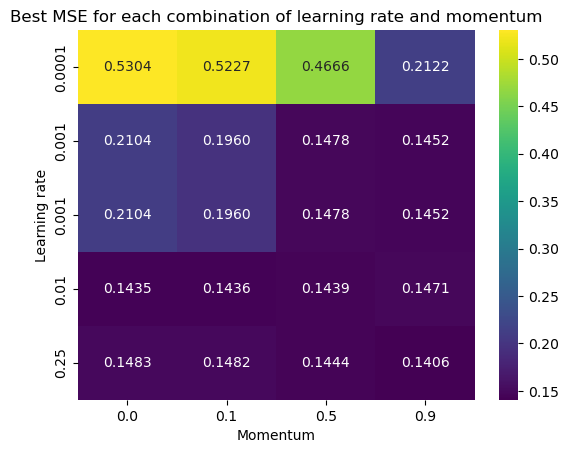

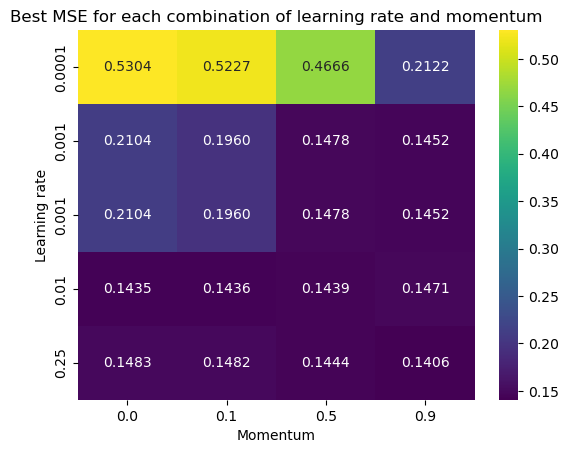

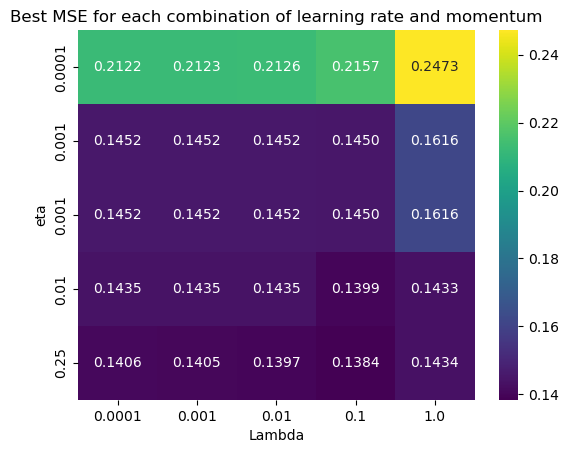

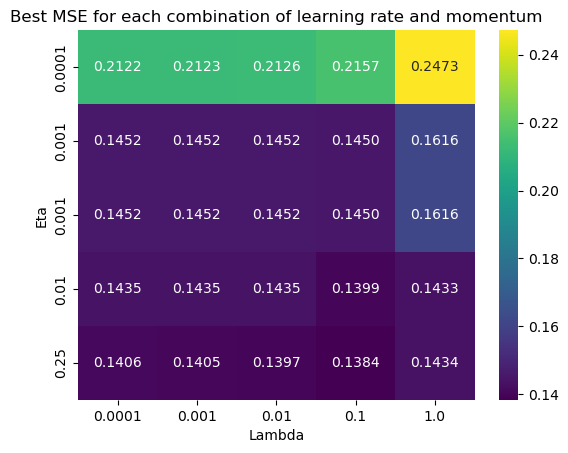

best gamma for each cell
[[0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9]
 [0.  0.  0.  0.9 0.9]
 [0.9 0.9 0.9 0.9 0.9]]


In [ ]:
import seaborn as sns


all_momentum_scores = np.array((scoresSgd , scoresSgdJax ))
for scores in all_momentum_scores:
    plt.figure()
    ax = sns.heatmap(np.min(scores,axis=2), annot=True, fmt=".4f", cmap="viridis")
    ax.set_title("Best MSE for each combination of learning rate and momentum")
    ax.set_xlabel("Momentum")
    ax.set_xticklabels(gammas)
    ax.set_ylabel("Learning rate")
    ax.set_yticklabels(etas)
    plt.show()



plt.figure()
ax = sns.heatmap(np.min(scoresRidge,axis=(1,3)), annot=True, fmt=".4f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Lambda")
ax.set_xticklabels(alphas)
ax.set_ylabel("eta")
ax.set_yticklabels(etas)
plt.show()

plt.figure()
ax = sns.heatmap(np.min(scoresRidgeJax,axis=(1,3)), annot=True, fmt=".4f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Lambda")
ax.set_xticklabels(alphas)
ax.set_ylabel("Eta")
ax.set_yticklabels(etas)
plt.show()

bestGamma = np.argmin(np.min(scoresRidge,axis=3),axis=1)
print("best gamma for each cell")
print(np.array((gammas,gammas))[0,bestGamma])

# Automatic differentiation

In [ ]:
from jax import grad

# overwrite the gradient methopd to use jax
def gradients(X, t, N, w):
    return grad(MSE)(w, X, t) 

In [ ]:
scoresAdagrad, scoresRmsprop, scoresAdam, scoresAdagradJax, scoresRmspropJax, scoresAdamJax, scoresHessianGd, scoresSgd, scoresSgdJax, scoresRidge, scoresRidgeJax = runSTG()

<__main__.JaxLinRegHessianInv object at 0x7fb0aed23f40> Early stopping at epoch 71                  Progress: [>                   ] 0%
<__main__.JaxLinRegHessianInv object at 0x7fb0aed3a290> Early stopping at epoch 83                  Progress: [>                   ] 5%
<__main__.Adagrad object at 0x7fb0aed53ac0> Did not converge after 199 epochs                       

KeyboardInterrupt: 

In [ ]:

all_momentum_scores = np.array((scoresSgd , scoresSgdJax ,scoresAdagrad, scoresAdagradJax ))
for scores in all_momentum_scores:
    ax = sns.heatmap(np.min(scores,axis=2), annot=True, fmt=".3f", cmap="viridis")
    plt.figure()
    ax.set_title("Best MSE for each combination of learning rate and momentum")
    ax.set_xlabel("Momentum")
    ax.set_xticklabels(gammas)
    ax.set_ylabel("Learning rate")
    ax.set_yticklabels(etas)
    plt.show()

scores_rest = np.array((scoresHessianGd, scoresRmsprop, scoresAdam, scoresRmspropJax, scoresAdamJax))
for scores in scores_rest:
    ax = sns.heatmap(scores, annot=True, fmt=".3f", cmap="viridis")
    plt.figure()
    ax.set_title("Best MSE for each combination of learning rate and momentum")
    ax.set_xlabel("Epochs")
    ax.set_xticklabels(np.linspace(0,epochs,25,dtype=int))
    ax.set_ylabel("Learning rate")
    ax.set_yticklabels(etas)
    plt.show()

ax = sns.heatmap(np.min(scoresRidge,axis=(0,3)), annot=True, fmt=".3f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Momentum")
ax.set_xticklabels(alphas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(gammas)
plt.show()

ax = sns.heatmap(np.min(scoresRidgeJax,axis=(0,3)), annot=True, fmt=".3f", cmap="viridis")
ax.set_title("Best MSE for each combination of learning rate and momentum")
ax.set_xlabel("Momentum")
ax.set_xticklabels(alphas)
ax.set_ylabel("Learning rate")
ax.set_yticklabels(gammas)
plt.show()